# X-Ray Image Classification Project

Phase 4 Project by Bella Scribner
- Flex
- Instructor: Morgan Jones
- Bog:
- Date of Review:

# Abstract

- Abstract here.

# Introduction

## The Business Problem


### Pneumonia

Pneumonia is the cause of over 725,000 children under the age of 5 worldwide, around 190,000 being newborns ([World Health Organization](https://www.who.int/news-room/fact-sheets/detail/pneumonia) and [UNICEF](https://www.unicef.org/stories/childhood-pneumonia-explained)). There are many different kinds of pneumonia -- bacterial, fungal, and viral -- but ultimately it is an infection of the lungs where the alveoli (the small sacks at the end of the bronchiole) fill up with pus and fluid making breathing painful and limiting oxygen intake.  As the most common type of pneumonia infection is bacterial, treatment is often as easy as taking a round of antibiotics.  For more severe cases of pneumonia that require hospitalization, oxygen is supplied to the patient if available.

One of the most common ways to diagnois if a patient has contracted pneumonia is to examine a chest x-ray, looking for white spots in the lungs (called infilrates) ([RadiologyInfo.org](https://www.radiologyinfo.org/en/info/pneumonia#:~:text=When%20interpreting%20the%20x%2Dray,(fluid%20surrounding%20the%20lungs).)).  Examining these chest x-rays can also be useful in indentifying if any complications related to pneumonia, such as abscesses or pleural effusions (fluid surrounding the lungs), have arisin.

Treatment of pneumonia is usually a simple and fairly inexpensive round of antibiotics due to the fact that the most common type of pneumonia is bacterial.  A vast majority of death caused by pneumonia are concentratied in the world's poorest countries (southern Asia and sub-Sarahn Africa), where there is an astronomical lack of robust health care systems. This inlucdes a shortage of doctors and lack of access to x-rays and labs.  

### UNICEF and Neural Labs Africa

UNICEF is actively working to fight the number of deaths by pneumonia (among many other global health related issues).  One of the ways they are doing this is through their [Venture Fund](https://www.unicef.org/innovation/venturefund/ai-ds-learning-health-cohort) which supports many different machine learning focused companies that are working to improve health care services world wide.  One such company is [Neural Labs Africa](https://neurallabs.africa/#) (see [UNICEF Neural Labs Africa](https://www.unicefventurefund.org/story/neural-labs-using-ai-accelerate-medical-imaging-diagnosis-respiratory-diseases)).  Neural Labs Africa is working to leverage AI to "democratize access to diagnostic healthcare" and improve patient care. Their product NeuralSight for Chest Imaging is capable of identifying, labeling and highlighting over 20 respiratory diseases, one of which is pneumonia.  

While what Neural Labs Africa is accomplishing is widely outside the scope of this project, it does serve as the inspiration.  The idea of expanding health care to areas that most need it, in this case by offering real time diagnoses.  

A vastly important note while we consider both this project, and utilizing AI on a broader scale to improve health care world wide -- most of the world, espcially those areas where deaths cause by pneumonia are most prevelant, do not have access to x-ray technology.  This, to say it lightly, puts a damper on the excitment surrounding these technological achievements.  Not to say they are not impresive and ###, but they mean nothing if they are not applicable and usable by the affected communities.  

It is imperitive that access to basic health care services, including access to a mobile x-ray machine, be provided.  Only then can predictive models like these really make an impact in suffering communities -- even if easy access to a doctor or hospital is not available.  That is when we will see these real time diagnoses be impactful in saving lives. 

### This Project | The Business + Business Problem

As mentioned above, Neural Labs Africa working with UNICEF is the inspiriation of this project.  To give this project a solid frame of reference, we will posit a non-profit organization as the business.  Furthermore, the specific project is produce a machine learning program that takes in pediatric chest x-rays and predict whether or not that patient has pneumonia.  For our purposes, this will be implemented as a screening process -- the idea is that patients who are further away from hospitals and other more robust health care systems, but also have access to mobile x-ray machines can benifit from this machine learning model.  If the model predicts that the patient has pneumonia, then further steps can be taken to treat that patient (the image can be sent to an off-site docture who can then confirm diagnosis + prescribe antibiotics), and the patient's family can make steps to get their child the treatment they need to survive. 

It is important that we capture as many patients as possible with pneumonia to prevent completely avoidable deaths.  However, placing an undue burdon on patients who are not sick must also be prevented whenever possible. 

- Flush this bit out just a little more later!!

#### Notes
- Who is the business and what is the project about and why?  What is the business looking for?  (what evaluation metrics might be most applicable based on this evaluation?)

- [WHO](https://www.who.int/news-room/fact-sheets/detail/pneumonia)
- [UNICEF](https://www.unicef.org/stories/childhood-pneumonia-explained)

- "biggest infectious killer of children worldwide"
- "more than 725,000 children under age of 5, including around 190,000 newborns, who are particularly vulnerable to infection"

- bacterial, fungal, or viral (different kinds)
- infection of the lungs which fill up with liquid (alveoli fill with pus and fluid) --> makes breathing painful and limits oxygen intake

- deaths highest in southern Asia + sub-Saharan Africa -- concentrated in the world's poorest countries
- areas without strong health care systems health workers often rely on diagnosing pneumonia by counting # of breath per min.  (few doctors, lack of access to chest x-rays + labs)
    - MAKES IDEA OF THIS PROJECT HARD --> idea is to expand access to health care, make it easier to diagnose, but this project needs an x-ray which then limits who can benefit from it...

- treatment depends on type of --> antibiotics if bacterial (most common), oxygen if available (for all types, but generally only more sever cases)

- chest x-rays are used to diagnos pneumonia based on the inflamation of the lungs
- [RadiologyInfo.org](https://www.radiologyinfo.org/en/info/pneumonia#:~:text=When%20interpreting%20the%20x%2Dray,(fluid%20surrounding%20the%20lungs).)
- look for white spots in the lungs (called infilrates) that id an infection)  also helps determine if have complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs)



- This project --> create a model that can be used as a pre-screening for patients, giving a prediction on whether or not the patient has pneumonia.  Based on the seriousness of pneumonia in children, will want to evaluate our model with more than just accuracy -- think precision :)

## The Data Source

- Reproducability!  Make sure to include how to download/access. Also note which versions using in this lab of each python library.

- Data Downloaded from Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

In [ ]:
import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import numpy as np
np.random.seed(88)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import regularizers

import tensorflow as tf
from tensorflow.
tf.random.set_seed(88)

from sklearn.metrics import confusion_matrix

import time
import pandas as pd

In [6]:
# Versions
import sys
import matplotlib
import keras
import sklearn
print('Versions of all libraries:')
print('\tPython | ',sys.version[:5])
print('\tNumpy |', np.__version__)
print('\tMatplotlib | ', matplotlib.__version__)
print('\tSeaborn | ', sns.__version__)
print('\tKeras | ', keras.__version__)
print('\tTensorflow | ', tf.__version__)
print('\tScikit-Learn | ', sklearn.__version__)

Versions of all libraries:
	Python |  3.8.5
	Numpy | 1.18.5
	Matplotlib |  3.3.1
	Seaborn |  0.11.0
	Keras |  2.4.3
	Tensorflow |  2.3.1
	Scikit-Learn |  1.3.2


# Data Exploration

## The overview
- From notes of last review --> keep this more contextual and word driven on the front end.  Can talk about results on the back end but want it mostly connected to the header!  
- Don't forget to include target distribution as well as visuals of data in general.

- Talk about all the things, referencing below here!

## Detailed exploration

- image sample
- distribution of target

### Working in Google CoLab and Forking from GitHub
- If you have opened the index in Google CoLab --> uncomment ALL cells below
- If forked from github (including the folder with the data in it, skip down to ###
- If have index.ipynb file and have downloaded data from Kaggle directly, uncomment cells starting with 'Structureof the raw downloaded data'

- Maybe make a markdown file with more detailed instructions :D 

In [3]:
# Prep Google CoLab to retrieve data from Kaggle

#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#username = ''  ## Your Kaggle username
#api_key = ''  ## Your Kaggle API key

#api_token = {"username": username,
#             "key": api_key}

#import json

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# This cell downloads the dataset from Kaggle
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [5]:
# This cell unzips the downloaded data
#shutil.unpack_archive('chest-xray-pneumonia.zip', '/content')

In [6]:
# structure of the raw downloaded data
#print(os.listdir('./chest_xray'))

# structure of train folder
#print(os.listdir('./chest_xray/train'))

In [7]:
#print(len(os.listdir('./chest_xray/train/NORMAL')))

Looks like we have our data structured such that it is already divided into Train, Validation, and Test segments.  Within those folders the images are stored in two folders based on whether the image is one where pneumonia is present or not.  Let's take a look at the distribution of our target within the train data.

In [8]:
#len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
#len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
#len_total_train = len_normal_train + len_pneu_train

#print("There are", len_normal_train, "normal xrays in the training set.")
#print("There are", len_pneu_train, "pneumonia xrays in the training set.")
#print("There are", len_total_train, "images total in the training set.\n")

#print('Target Distributon:')
#print('{}% normal'.format(round(len_normal_train/len_total_train * 100, 2)))
#print('{}% pneumonia'.format(round(len_pneu_train/len_total_train * 100, 2)))

In [9]:
#len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
#len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
#len_total_val = len_normal_val + len_pneu_val

#len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
#len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
#len_total_test = len_normal_test + len_pneu_test

#print("There are", len_total_val, "images total in the validation set.")
#print("There are", len_total_test, "images total in the test set.")

In [10]:
#num_images_total = len_total_train + len_total_val + len_total_test
#print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
#print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
#print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

So it looks like we do not have a very good split between our training and validation data -- having only 16 images / less than 1% of our data to validate with will lead to higher variance in our evaluation metrics when trying to optimize our models.  

Need to move random 5% of train/pneumonia images and 5% of train/normal images into corresponding validation folder to fix this distribution.

In [11]:
# How many images to move over -- 10% of total train data.  
#len_total_train * .1  / 2

In [12]:
# Create lists of file names for train normal + train pneumonia

#normal_train_images = [file for file in os.listdir('./chest_xray/train/NORMAL')]
#pneu_train_images = [file for file in os.listdir('./chest_xray/train/PNEUMONIA')]

# randomly choose indicies for 5% of data (both normal + pneumonia)
#normal_inds = np.random.choice(range(len_normal_train), size=260, replace=False)
#pneu_inds = np.random.choice(range(len_pneu_train), size=260, replace=False)

In [13]:
# move chosen images to validatoin folders
## Uncomment cell and run code

#for i in normal_inds:
#    image = normal_train_images[i]
#    origin = './chest_xray/train/NORMAL/' + image
#    destination = './chest_xray/val/NORMAL/' + image
#    shutil.move(origin, destination)
    
#for i in pneu_inds:
#    image = pneu_train_images[i]
#    origin = './chest_xray/train/PNEUMONIA/' + image
#    destination = './chest_xray/val/PNEUMONIA/' + image
#    shutil.move(origin, destination)

In [7]:
len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
len_total_train = len_normal_train + len_pneu_train

len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
len_total_val = len_normal_val + len_pneu_val

len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
len_total_test = len_normal_test + len_pneu_test

print("There are", len_total_train, "images total in the training set.")
print("There are", len_total_val, "images total in the validation set.")
print("There are", len_total_test, "images total in the test set.\n")

num_images_total = len_total_train + len_total_val + len_total_test
print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

There are 4696 images total in the training set.
There are 536 images total in the validation set.
There are 624 images total in the test set.

Using 80.19% of data to train
Using 9.15% of data to validate
Using 10.66% of data to test


In [8]:
print('Target Distributon:')
print('{}% normal'.format(round(len_normal_train/len_total_train * 100, 2)))
print('{}% pneumonia'.format(round(len_pneu_train/len_total_train * 100, 2)))

Target Distributon:
23.02% normal
76.98% pneumonia


In [ ]:
# Add graph here of target distribution :D

That isn't quite 80/10/10 split, but much better than before and will be a good split for this project.  We have a rather unbalanced target distribution.  This might need to be addressed when processing the data in preparation of modeling.

In [9]:
# take a look at some images

train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# all images will be rescaled by 1./225
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    # resize images down to 150x150
                                                    target_size=(150,150),
                                                    # process in 587 batches
                                                    batch_size=8,
                                                    # target is binary
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150,150),
                                                batch_size=8,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=8,
                                                  class_mode='binary')

Found 4696 images belonging to 2 classes.
Found 536 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# Create a data sets
## Warning!  This cell might take some time to run
train_images = []
train_labels = []

val_images = []
val_labels = []

test_images = []
test_labels = []

start_time = time.time()

for batch in range(587):
    train_i, train_l = next(train_generator)
    train_images.append(train_i)
    train_labels.append(train_l)
    
for batch in range(67):
    val_i, val_l = next(val_generator)
    val_images.append(val_i)
    val_labels.append(val_l)
    
for batch in range(78):
    test_i, test_l = next(test_generator)
    test_images.append(test_i)
    test_labels.append(test_l)
    
end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Execution Time: 176


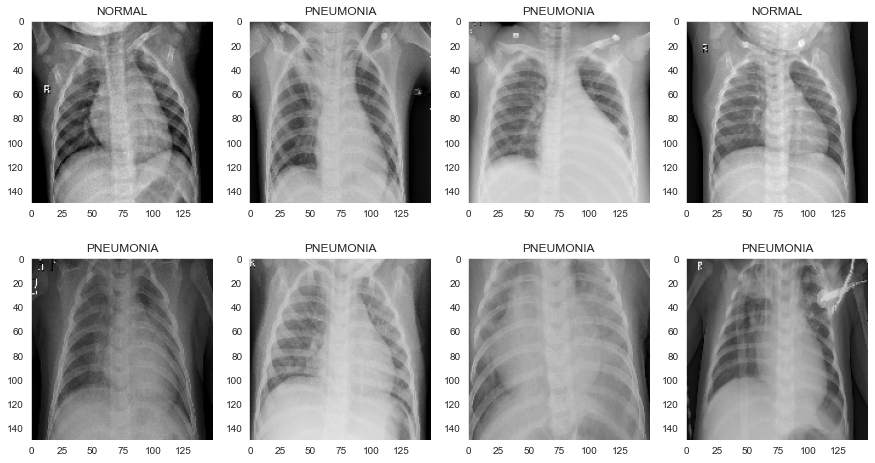

In [11]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
classes = list(train_generator.class_indices.keys())

for i in range(8):
    row = i // 4 
    col = i % 4
    ax = axes[row, col]

    ax.imshow(train_images[0][i])
    label = int(train_labels[0][i])
    ax.set_title(classes[label])

In [ ]:
# Plot image + histogram of pixe intensities
plt.imshow(<picture>)
plt.axis('off')

plt.hist(<picture>[:,:,0].flatten(), bins=number, lw=0, color= 'r', alpha=0.5)
plt.hist(<picture>[:,:,1].flatten(), bins=number, lw=0, color= 'r', alpha=0.5)
plt.hist(<picture>[:,:,2].flatten(), bins=number, lw=0, color= 'r', alpha=0.5)

OR

colors = ('red', 'green', 'blue')
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(<picture>[:,:,channel_id]), bins=numb, range=(0,1)
    plt.plot(bin_edges[0], histogram, color=color)

# Model Iteration

## Baseline Model

- Baseline model is Dense Neural Network -- then will iterate through a CNN, then optimize that CNN (assuming does better)

- Build Model (Dense model as base line -- convolutonal in further iterations
- Evaluate with loss + accuracy curves

In [12]:
# Baseline model is Dense NN, thus need to reshape data prior to inputting
print('Train images shape:', train_images[0].shape)
print('Train labels shape:', train_labels[0].shape)
print('Validation images shape:', val_images[0].shape)
print('Validation labels shape:', val_labels[0].shape)
print('Test images shape:', test_images[0].shape)
print('Test labels shape:', test_labels[0].shape)

Train images shape: (8, 150, 150, 3)
Train labels shape: (8,)
Validation images shape: (8, 150, 150, 3)
Validation labels shape: (8,)
Test images shape: (8, 150, 150, 3)
Test labels shape: (8,)


In [40]:
# Reshape images
train_img_reshaped = train_images[0].reshape(train_images[0].shape[0],-1)
val_img_reshaped = val_images[0].reshape(val_images[0].shape[0],-1)

print(train_img_reshaped.shape)
print(val_img_reshaped.shape)

(8, 67500)
(8, 67500)


In [41]:
# Reshape Labels
train_labels_reshaped = train_labels[0].reshape(train_labels[0].shape[0],1)
val_labels_reshaped = val_labels[0].reshape(val_labels[0].shape[0],1)

print(train_labels_reshaped.shape)
print(val_labels_reshaped.shape)

(8, 1)
(8, 1)


In [42]:
# Reshape more batches and append to already reshaped arrays -- 25% data
for i in range(1,147):
    train_img_reshaped = np.concatenate((train_img_reshaped, train_images[i].reshape(train_images[i].shape[0], -1)))
    train_labels_reshaped = np.concatenate((train_labels_reshaped, train_labels[i].reshape(train_labels[i].shape[0], -1)))
    
for i in range(1,17):
    val_img_reshaped = np.concatenate((val_img_reshaped, val_images[i].reshape(val_images[i].shape[0], -1)))
    val_labels_reshaped = np.concatenate((val_labels_reshaped, val_labels[i].reshape(val_labels[i].shape[0], -1)))

In [16]:
# Build Baseline Model
baselinemodel = Sequential()

baselinemodel.add(layers.Dense(15, activation='relu', input_shape=(67500,)))
baselinemodel.add(layers.Dense(8, activation='relu'))
baselinemodel.add(layers.Dense(5, activation='relu'))

baselinemodel.add(layers.Dense(1, activation='sigmoid'))

baselinemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                1012515   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,012,694
Trainable params: 1,012,694
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile model
baselinemodel.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', 
                               tf.keras.metrics.Recall(), 
                               tf.keras.metrics.Precision()])

In [18]:
# Add an Early Stopping
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=4)

In [19]:
# Fit Model
start_time = time.time()
baseline_history = baselinemodel.fit(train_img_reshaped,
                                     train_labels_reshaped,
                                     epochs=40,
                                     validation_data=(val_img_reshaped, val_labels_reshaped),
                                     callbacks = [callback])

end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Epoch 1/40
37/37 [==============================] - 2s 56ms/step - loss: 0.6774 - accuracy: 0.7840 - recall: 0.9968 - precision: 0.7858 - val_loss: 0.7780 - val_accuracy: 0.4485 - val_recall: 1.0000 - val_precision: 0.4485
Epoch 2/40
37/37 [==============================] - 1s 24ms/step - loss: 0.4645 - accuracy: 0.7857 - recall: 1.0000 - precision: 0.7857 - val_loss: 0.9098 - val_accuracy: 0.4485 - val_recall: 1.0000 - val_precision: 0.4485
Epoch 3/40
37/37 [==============================] - 1s 24ms/step - loss: 0.3996 - accuracy: 0.7857 - recall: 1.0000 - precision: 0.7857 - val_loss: 0.6463 - val_accuracy: 0.4485 - val_recall: 1.0000 - val_precision: 0.4485
Epoch 4/40
37/37 [==============================] - 1s 25ms/step - loss: 0.3765 - accuracy: 0.7857 - recall: 1.0000 - precision: 0.7857 - val_loss: 0.7536 - val_accuracy: 0.4632 - val_recall: 1.0000 - val_precision: 0.4552
Epoch 5/40
37/37 [==============================] - 1s 25ms/step - loss: 0.3493 - accuracy: 0.8333 - recall:

In [20]:
def create_metric_lists(model_history, model, x_val_data, y_val_data):
    """
    This function takes in a fitted NN model that included the below metric list when compiled and outputs a list
    of the training metrics and a list of the validation metrics.
    """
    # get loss, accuracy, recall, and precision
    train_metrics = [model_history.history[i] for i in list(model_history.history.keys())[:4]]
    val_metrics = [model_history.history[i] for i in list(model_history.history.keys())[4:]]
    
    # calculate F1 score
    recall = np.array(train_metrics[2])
    precision = np.array(train_metrics[3])
    f1 = 2 * ((precision * recall) / (precision + recall))
    train_metrics.append(list(f1))
    
    recall = np.array(val_metrics[2])
    precision = np.array(val_metrics[3])
    f1 = 2 * ((precision * recall) / (precision + recall))
    val_metrics.append(list(f1))
    
    # Confusion Matrix
    cnfs_mtrx = confusion_matrix(y_val_data, np.where(model.predict(x_val_data) >= 0.5, 1,0))
    
    return train_metrics, val_metrics, cnfs_mtrx

In [21]:
# Keep track of models + metrics for easy side-by-side comparison
all_model_metrics = {'Model': [],
                    'Loss': [],
                    'Accuracy': [],
                    'Recall': [],
                    'Precision': [],
                    'F1 Score': [],
                    'Computation Time': [],
                    'Confusion Matrix': []}

def record_all(all_model_metrics, val_metrics, model_name, time, cnfs_mtrx, num_epochs):
    
    metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'F1 Score']
    
    all_model_metrics['Model'].append(model_name)
    
    for i,metric in enumerate(metrics):
        all_model_metrics[metric].append(val_metrics[i][-1])
    
    all_model_metrics['Computation Time per Epoch'].append(time/num_epochs)
    all_model_metrics['Confusion Matrix'].append(cnfs_mtrx)
    
    return all_model_metrics

In [22]:
def visualize_metrics(x, train_metrics, val_metrics, model_name, cnfs_mtrx):
    """
    -This function takes in an x (representing the number of epochs), a list of the training metrics, 
    and a list of the validation metrics.  These lists should contain a list for each metric used, specifically,
    in order, the model's loss, accuracy, recall, and precision per epoch.  
    -It also takes in a string of the model name used to title the visual.
    -The function outputs four graphs, one for each metric, with the training and validation data on the same axes.
    """
    
    metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'F1 Score']

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,13))
    for i in range(5):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        ax.plot(x,train_metrics[i], label='Train', color='b')
        ax.plot(x, val_metrics[i], label='Validation', color='r')
        ax.set_title(metrics[i], fontsize='x-large')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metrics[i])
        ax.grid(True)
        ax.legend()
    
    sns.heatmap(cnfs_mtrx, annot=True, ax=axes[1,2])
    axes[1,2].set_title('Confusion Matrix', fontsize='x-large')
    axes[1,2].set_xticklabels(['Normal', 'Pneumonia'])
    axes[1,2].set_yticklabels(['Normal', 'Pneumonia'])
    axes[1,2].set_xlabel('Predicted Label')
    axes[1,2].set_ylabel('True Label')
        
    plt.suptitle('{} Metrics'.format(model_name), fontsize='xx-large')
    plt.tight_layout()

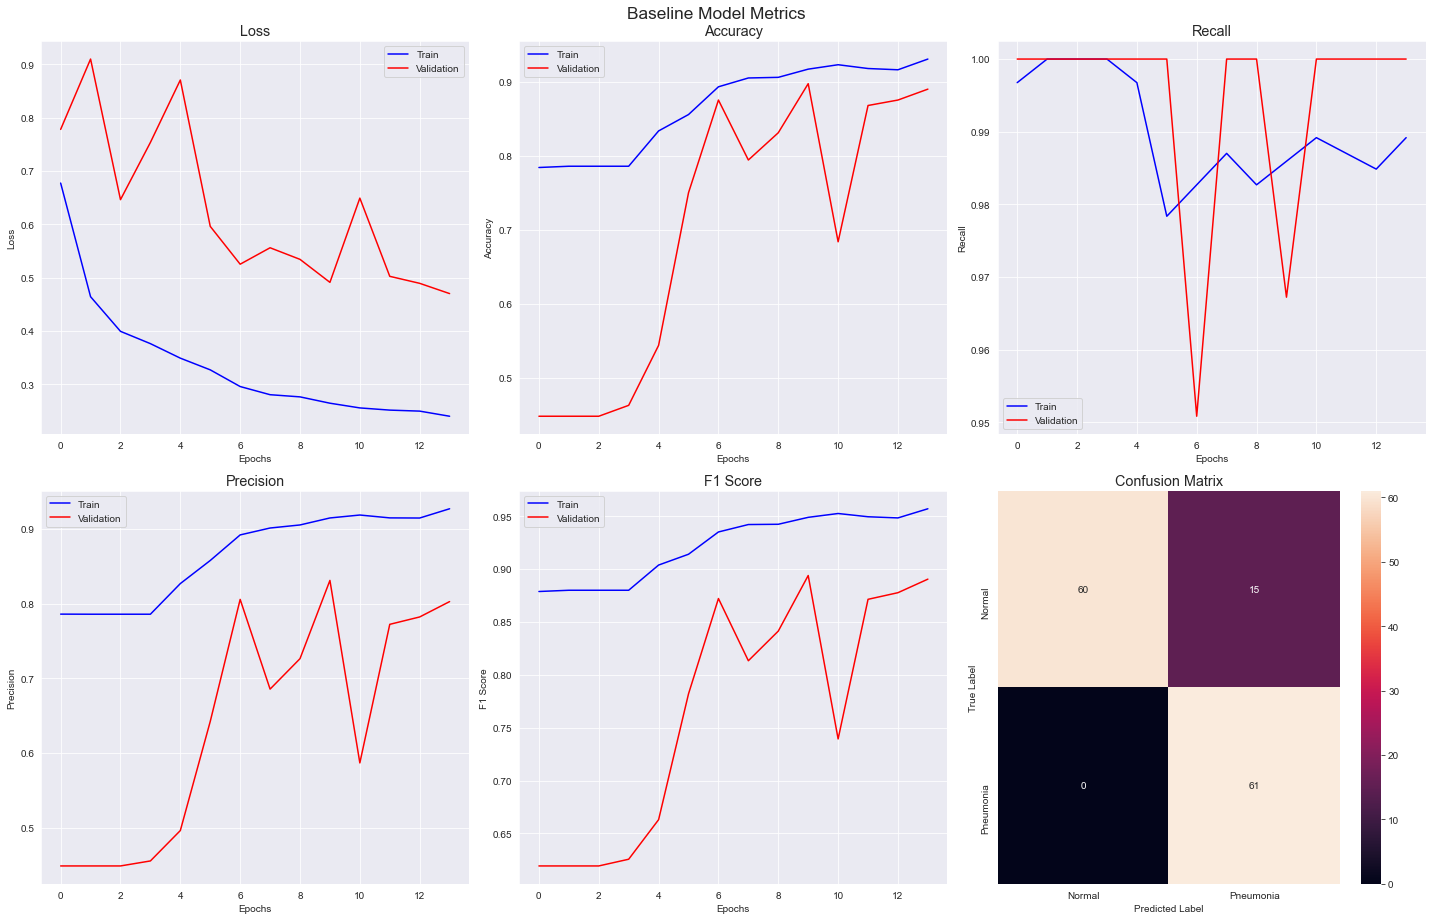

In [23]:
train_metrics, val_metrics, cnfs_mtrx = create_metric_lists(baseline_history, 
                                                                   baselinemodel, 
                                                                   val_img_reshaped, 
                                                                   val_labels_reshaped)
all_model_metrics = record_all(all_model_metrics, 
                               val_metrics, 
                               'Baseline Model', 
                               execution_time, 
                               cnfs_mtrx,
                               callback.stopped_epoch)

visualize_metrics(range(callback.stopped_epoch+1), train_metrics, val_metrics, 'Baseline Model', cnfs_mtrx)

We can see that our validation results are not great.  Recall is not the best metric to evaluate this model with because of the class imbalance, although due to the nature of our project, we do not want to completely ignore it.  With Recall jumping up to 100% but precision and accuracy of the validation data much lower than the training data, we can safely assume and see that our model is overfitting.

Let's see if we can improve this by (1) using more of the data itself (currently we are only using an eighth of our available training data), (2) using a convolution neural network to help decrease overfitting, and (3) try applying a/some regularization techniques such as dropout to decrease overfitting.

## Same Model Structure as above, but with more data.

First, let's see if we can increase the performance of this baseline model by simply using more data.  This will mean increased time -- we will have to weigh if the time cost is worth the increase we see.  We will try using 75%.

In [46]:
# Reshape more batches and append to already reshaped arrays --- 75% data
for i in range(147,441):
    train_img_reshaped = np.concatenate((train_img_reshaped, train_images[i].reshape(train_images[i].shape[0], -1)))
    train_labels_reshaped = np.concatenate((train_labels_reshaped, train_labels[i].reshape(train_labels[i].shape[0], -1)))
    
for i in range(17,51):
    val_img_reshaped = np.concatenate((val_img_reshaped, val_images[i].reshape(val_images[i].shape[0], -1)))
    val_labels_reshaped = np.concatenate((val_labels_reshaped, val_labels[i].reshape(val_labels[i].shape[0], -1)))

In [25]:
print(train_img_reshaped.shape)
print(val_img_reshaped.shape)
print(train_labels_reshaped.shape)
print(val_labels_reshaped.shape)

(3528, 67500)
(408, 67500)
(3528, 1)
(408, 1)


In [26]:
# Rebuild Model
baselinemodel_75 = Sequential()

baselinemodel_75.add(layers.Dense(15, activation='relu', input_shape=(67500,)))
baselinemodel_75.add(layers.Dense(8, activation='relu'))
baselinemodel_75.add(layers.Dense(5, activation='relu'))

baselinemodel_75.add(layers.Dense(1, activation='sigmoid'))

In [27]:
# Compile model
start_time = time.time()
baselinemodel_75.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Add an Early Stopping
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=4)
# Fit Model
baseline_75_history = baselinemodel_75.fit(train_img_reshaped,
                                     train_labels_reshaped,
                                     epochs=40,
                                     batch_size=35,
                                     validation_data=(val_img_reshaped, val_labels_reshaped),
                                     callbacks=[callback])
end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Epoch 1/40
101/101 [==============================] - 4s 36ms/step - loss: 0.6918 - accuracy: 0.7664 - recall_1: 0.9890 - precision_1: 0.7727 - val_loss: 0.6932 - val_accuracy: 0.4951 - val_recall_1: 1.0000 - val_precision_1: 0.4951accuracy: 0.7652 - recall_1: 0.9858 - precisio
Epoch 2/40
101/101 [==============================] - 2s 24ms/step - loss: 0.6889 - accuracy: 0.7735 - recall_1: 1.0000 - precision_1: 0.7735 - val_loss: 0.6933 - val_accuracy: 0.4951 - val_recall_1: 1.0000 - val_precision_1: 0.4951
Epoch 3/40
101/101 [==============================] - 2s 24ms/step - loss: 0.6863 - accuracy: 0.7735 - recall_1: 1.0000 - precision_1: 0.7735 - val_loss: 0.6934 - val_accuracy: 0.4951 - val_recall_1: 1.0000 - val_precision_1: 0.4951
Epoch 4/40
101/101 [==============================] - 2s 24ms/step - loss: 0.6838 - accuracy: 0.7735 - recall_1: 1.0000 - precision_1: 0.7735 - val_loss: 0.6935 - val_accuracy: 0.4951 - val_recall_1: 1.0000 - val_precision_1: 0.4951
Epoch 5/40
101/101 [==

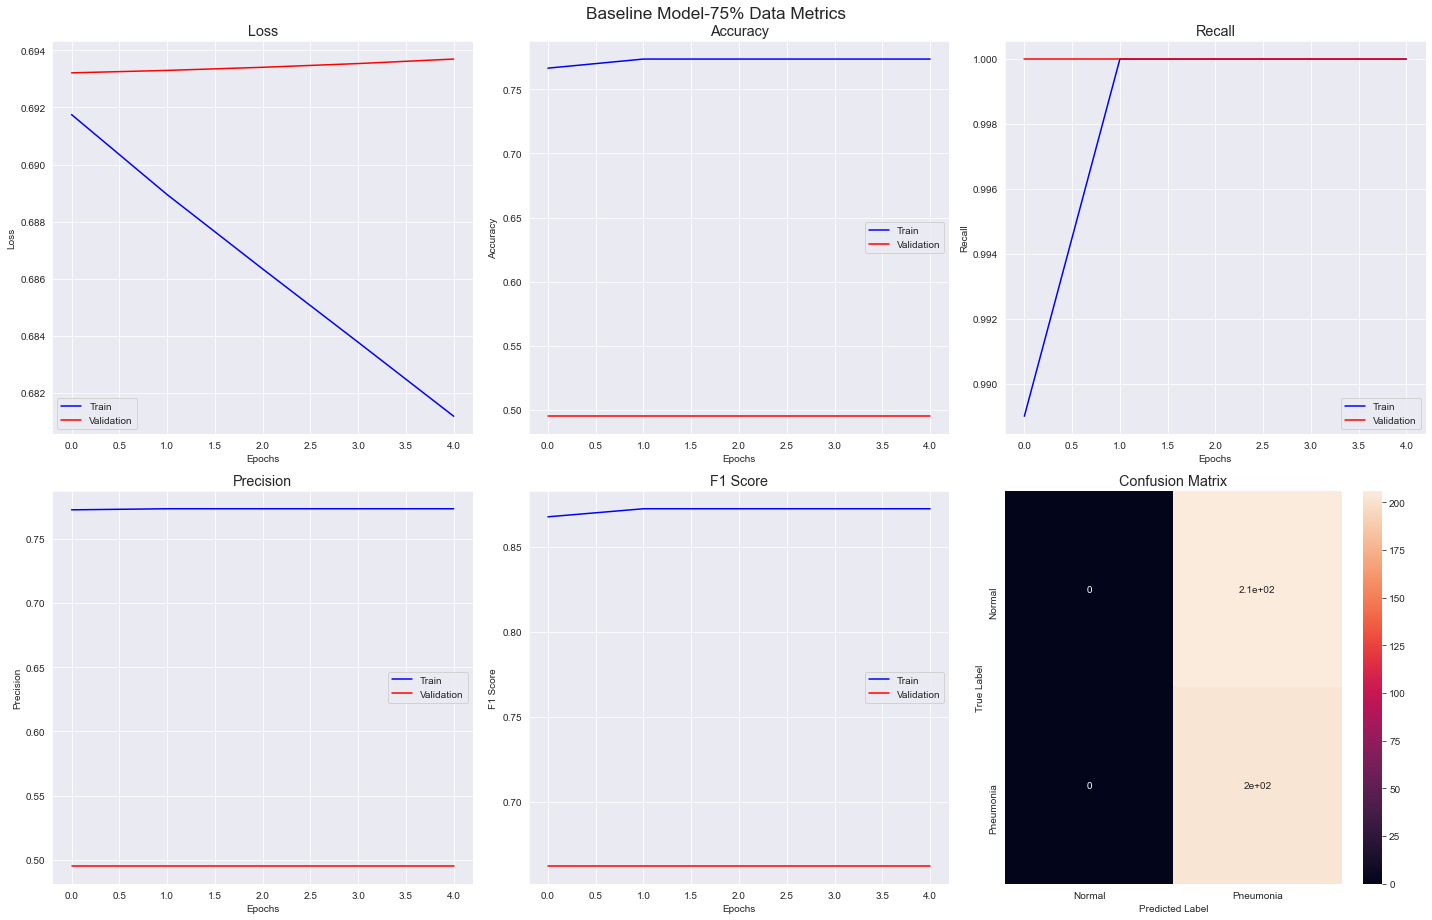

In [29]:
# Visualize Results
train_metrics, val_metrics, cnfs_mtrx = create_metric_lists(baseline_75_history,
                                                           baselinemodel_75,
                                                           val_img_reshaped,
                                                           val_labels_reshaped)

all_model_metrics = record_all(all_model_metrics, 
                              val_metrics,
                              'Baseline 75',
                              execution_time,
                              cnfs_mtrx,
                              callback.stopped_epoch)

visualize_metrics(range(callback.stopped_epoch+1), train_metrics, val_metrics, 'Baseline Model-75% Data', cnfs_mtrx)

At a glance, we can see that adding more data actually made our model worse!  Let's move on to convolutional neural network to see if that improves our performance.  Based on the fact that we are clearly overfitting, this seems like the best approach.

## Model 2

- CNN --> CNNs take in the image itself (not reshaped) as the input


In [33]:
# Build the model

cnn = Sequential()

cnn.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(32, (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(20, (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Flatten())

cnn.add(layers.Dense(80, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 20)        5780      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5780)             

In [34]:
# Comiple Model
cnn.compile(loss='binary_crossentropy',
           optimizer='adam',
           metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [35]:
start_time = time.time()

# Add an Early Stopping
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=4)

# Train Model
cnn_history = cnn.fit(train_generator,
                     epochs=40,
                     validation_data = val_generator,
                     callbacks=[callback])

end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Epoch 1/40
587/587 [==============================] - 239s 407ms/step - loss: 0.2369 - accuracy: 0.9063 - recall_2: 0.9602 - precision_2: 0.9214 - val_loss: 0.2188 - val_accuracy: 0.9142 - val_recall_2: 0.9776 - val_precision_2: 0.8675
Epoch 2/40
587/587 [==============================] - 237s 403ms/step - loss: 0.1108 - accuracy: 0.9587 - recall_2: 0.9762 - precision_2: 0.9703 - val_loss: 0.1158 - val_accuracy: 0.9664 - val_recall_2: 0.9851 - val_precision_2: 0.9496
Epoch 3/40
587/587 [==============================] - 239s 407ms/step - loss: 0.0822 - accuracy: 0.9687 - recall_2: 0.9801 - precision_2: 0.9793 - val_loss: 0.1135 - val_accuracy: 0.9590 - val_recall_2: 0.9888 - val_precision_2: 0.9331
Epoch 4/40
587/587 [==============================] - 246s 419ms/step - loss: 0.0688 - accuracy: 0.9723 - recall_2: 0.9823 - precision_2: 0.9818 - val_loss: 0.1604 - val_accuracy: 0.9515 - val_recall_2: 0.9813 - val_precision_2: 0.9261
Epoch 5/40
587/587 [==============================] - 24

In [47]:
# Get rest of labeled validation data    
for i in range(51,67):
    val_labels_reshaped = np.concatenate((val_labels_reshaped, val_labels[i].reshape(val_labels[i].shape[0], -1)))

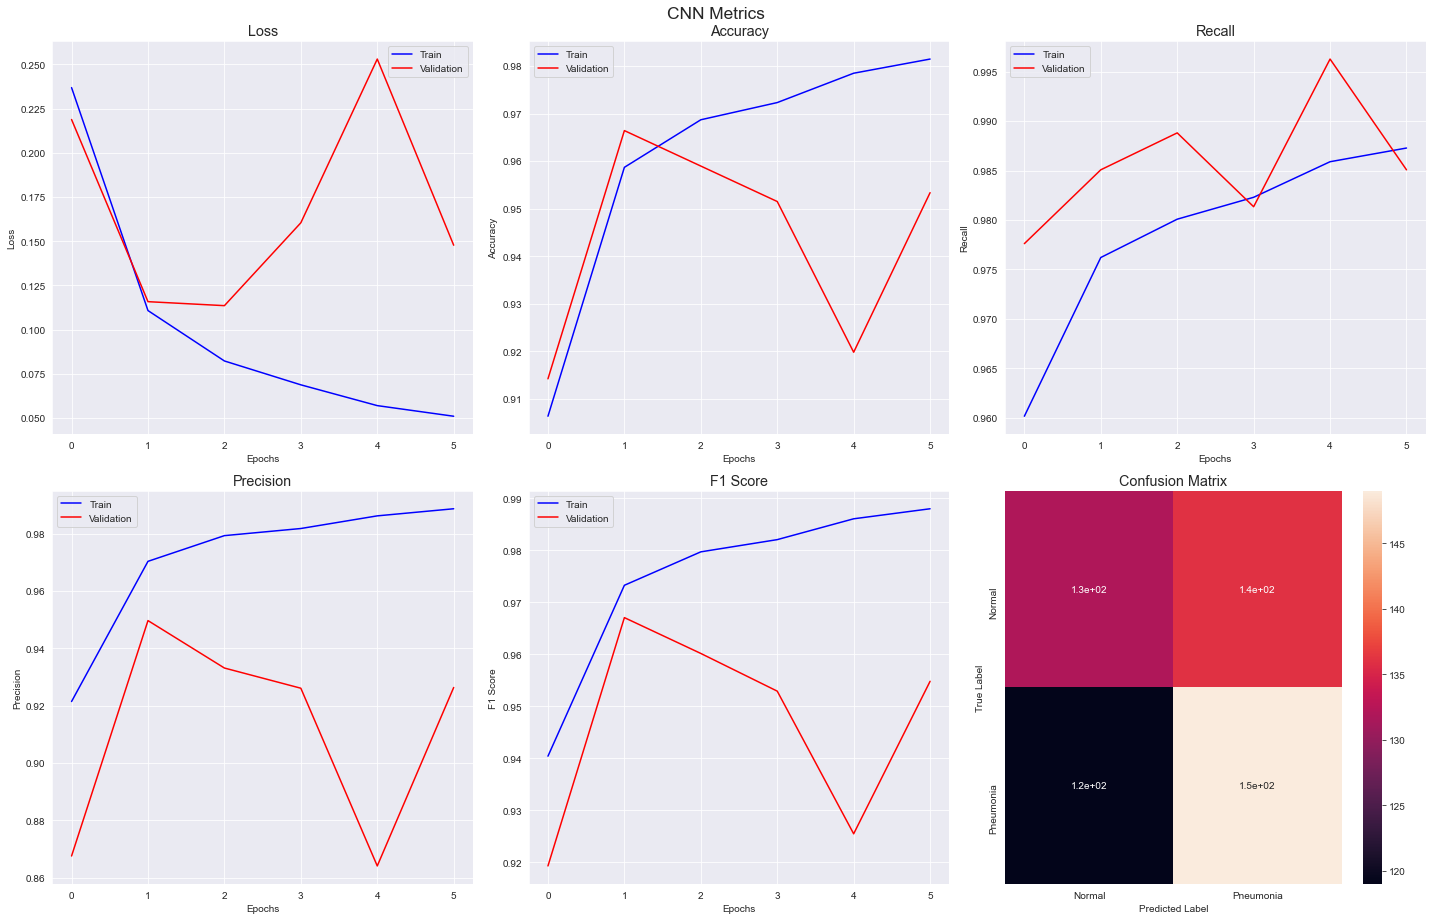

In [49]:
train_metrics, val_metrics, cnfs_mtrx = create_metric_lists(cnn_history,
                                                            cnn,
                                                            val_generator,
                                                            val_labels_reshaped)
all_model_metrics = record_all(all_model_metrics, 
                               val_metrics, 
                               'CNN', 
                               execution_time, 
                               cnfs_mtrx,
                               callback.stopped_epoch)

visualize_metrics(range(callback.stopped_epoch+1), train_metrics, val_metrics, 'CNN', cnfs_mtrx)

In [39]:
# Small Analysis of the model here

## Model 3

- optimize CNN (assuming better than Dense NN)



In [50]:
# Add in drop out layers + regularilization

cnn_reg = Sequential()

cnn_reg.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))

cnn_reg.add(layers.MaxPooling2D((2,2)))
cnn_reg.add(layers.Dropout(0.3))

cnn_reg.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_reg.add(layers.MaxPooling2D((2,2)))
cnn_reg.add(layers.Dropout(0.3))

cnn_reg.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_reg.add(layers.MaxPooling2D((2,2)))
cnn_reg.add(layers.Dropout(0.3))


cnn_reg.add(layers.Conv2D(20, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_reg.add(layers.MaxPooling2D((2,2)))

cnn_reg.add(layers.Flatten())

cnn_reg.add(layers.Dense(80, activation='relu'))
cnn_reg.add(layers.Dense(1, activation='sigmoid'))

cnn_reg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)       

In [51]:
# Comiple Model
cnn_reg.compile(loss='binary_crossentropy',
           optimizer='adam',
           metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [52]:
start_time = time.time()

# Add an Early Stopping
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=4)

# Train Model
cnn_reg_history = cnn_reg.fit(train_generator,
                     epochs=40,
                     validation_data = val_generator,
                     callbacks=[callback])

end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Epoch 1/40
587/587 [==============================] - 261s 444ms/step - loss: 0.5219 - accuracy: 0.8356 - recall_3: 0.9516 - precision_3: 0.8521 - val_loss: 0.3783 - val_accuracy: 0.8955 - val_recall_3: 0.8134 - val_precision_3: 0.9732
Epoch 2/40
587/587 [==============================] - 257s 438ms/step - loss: 0.2535 - accuracy: 0.9293 - recall_3: 0.9549 - precision_3: 0.9533 - val_loss: 0.2263 - val_accuracy: 0.9216 - val_recall_3: 0.9776 - val_precision_3: 0.8792
Epoch 3/40
587/587 [==============================] - 251s 427ms/step - loss: 0.1978 - accuracy: 0.9425 - recall_3: 0.9649 - precision_3: 0.9606 - val_loss: 0.1877 - val_accuracy: 0.9496 - val_recall_3: 0.9142 - val_precision_3: 0.9839
Epoch 4/40
587/587 [==============================] - 256s 436ms/step - loss: 0.1830 - accuracy: 0.9483 - recall_3: 0.9693 - precision_3: 0.9637 - val_loss: 0.1898 - val_accuracy: 0.9646 - val_recall_3: 0.9478 - val_precision_3: 0.9807
Epoch 5/40
587/587 [==============================] - 26

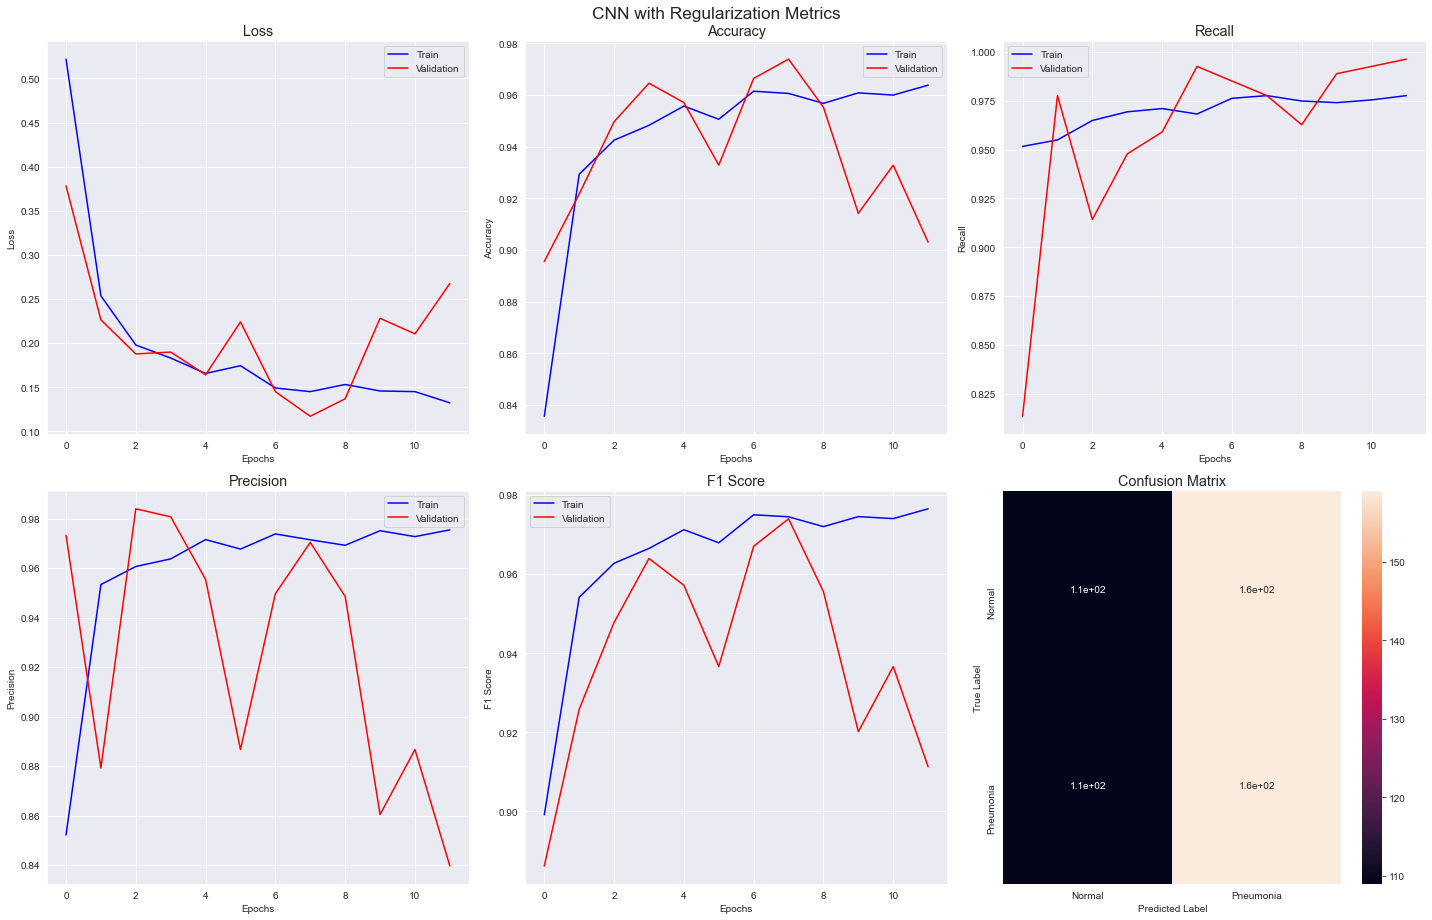

In [53]:
train_metrics, val_metrics, cnfs_mtrx = create_metric_lists(cnn_reg_history,
                                                            cnn_reg,
                                                            val_generator,
                                                            val_labels_reshaped)
all_model_metrics = record_all(all_model_metrics, 
                               val_metrics, 
                               'CNN with Reg', 
                               execution_time, 
                               cnfs_mtrx,,
                               callback.stopped_epoch)

visualize_metrics(range(callback.stopped_epoch+1), train_metrics, val_metrics, 'CNN with Regularization', cnfs_mtrx)

### Model 4

- Explore transfer learning!!
- (look at visualizations to see how model performing

In [54]:
#from tf.keras.applications import EfficientNetB3
cnn_base = tf.keras.applications.VGG19(weights='imagenet', 
                         include_top=False,
                         input_shape=(150,150,3),
                         pooling='max')

cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [55]:
transfer_model = Sequential()

transfer_model.add(cnn_base)
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(132, activation='relu'))
transfer_model.add(layers.Dense(1, activation='sigmoid'))

transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 132)               67716     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 133       
Total params: 20,092,233
Trainable params: 20,092,233
Non-trainable params: 0
_________________________________________________________________


In [56]:
for layer in transfer_model.layers:
    print(layer.name, layer.trainable)
    
print('Number of trainable weights: ', len(transfer_model.trainable_weights))

vgg19 True
flatten_2 True
dense_12 True
dense_13 True
Number of trainable weights:  36


In [57]:
# Freeze the 'cnn base'
cnn_base.trainable = False

# Sanity Check
for layer in transfer_model.layers:
    print(layer.name, layer.trainable)
    
print('Number of trainable weights: ', len(transfer_model.trainable_weights))

vgg19 False
flatten_2 True
dense_12 True
dense_13 True
Number of trainable weights:  4


In [58]:
start_time = time.time()

# Comiple Model
transfer_model.compile(loss='binary_crossentropy',
           optimizer='adam',
           metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Add an Early Stopping
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                             patience=4)

# Train Model
transfer_model_history = transfer_model.fit(train_generator,
                     epochs=40,
                     validation_data = val_generator,
                     callbacks=[callback])

end_time = time.time()
execution_time = end_time - start_time
print('Execution Time: {}'.format(round(execution_time),2))

Epoch 1/40
587/587 [==============================] - 599s 1s/step - loss: 0.1869 - accuracy: 0.9278 - recall_4: 0.9654 - precision_4: 0.9422 - val_loss: 0.2227 - val_accuracy: 0.9030 - val_recall_4: 0.9963 - val_precision_4: 0.8396
Epoch 2/40
587/587 [==============================] - 286s 486ms/step - loss: 0.1228 - accuracy: 0.9555 - recall_4: 0.9746 - precision_4: 0.9679 - val_loss: 0.3652 - val_accuracy: 0.8582 - val_recall_4: 0.9963 - val_precision_4: 0.7807
Epoch 3/40
587/587 [==============================] - 283s 483ms/step - loss: 0.1082 - accuracy: 0.9595 - recall_4: 0.9768 - precision_4: 0.9709 - val_loss: 0.1192 - val_accuracy: 0.9515 - val_recall_4: 0.9888 - val_precision_4: 0.9201
Epoch 4/40
587/587 [==============================] - 283s 482ms/step - loss: 0.0911 - accuracy: 0.9642 - recall_4: 0.9779 - precision_4: 0.9757 - val_loss: 0.0961 - val_accuracy: 0.9683 - val_recall_4: 0.9813 - val_precision_4: 0.9564
Epoch 5/40
587/587 [==============================] - 283s 

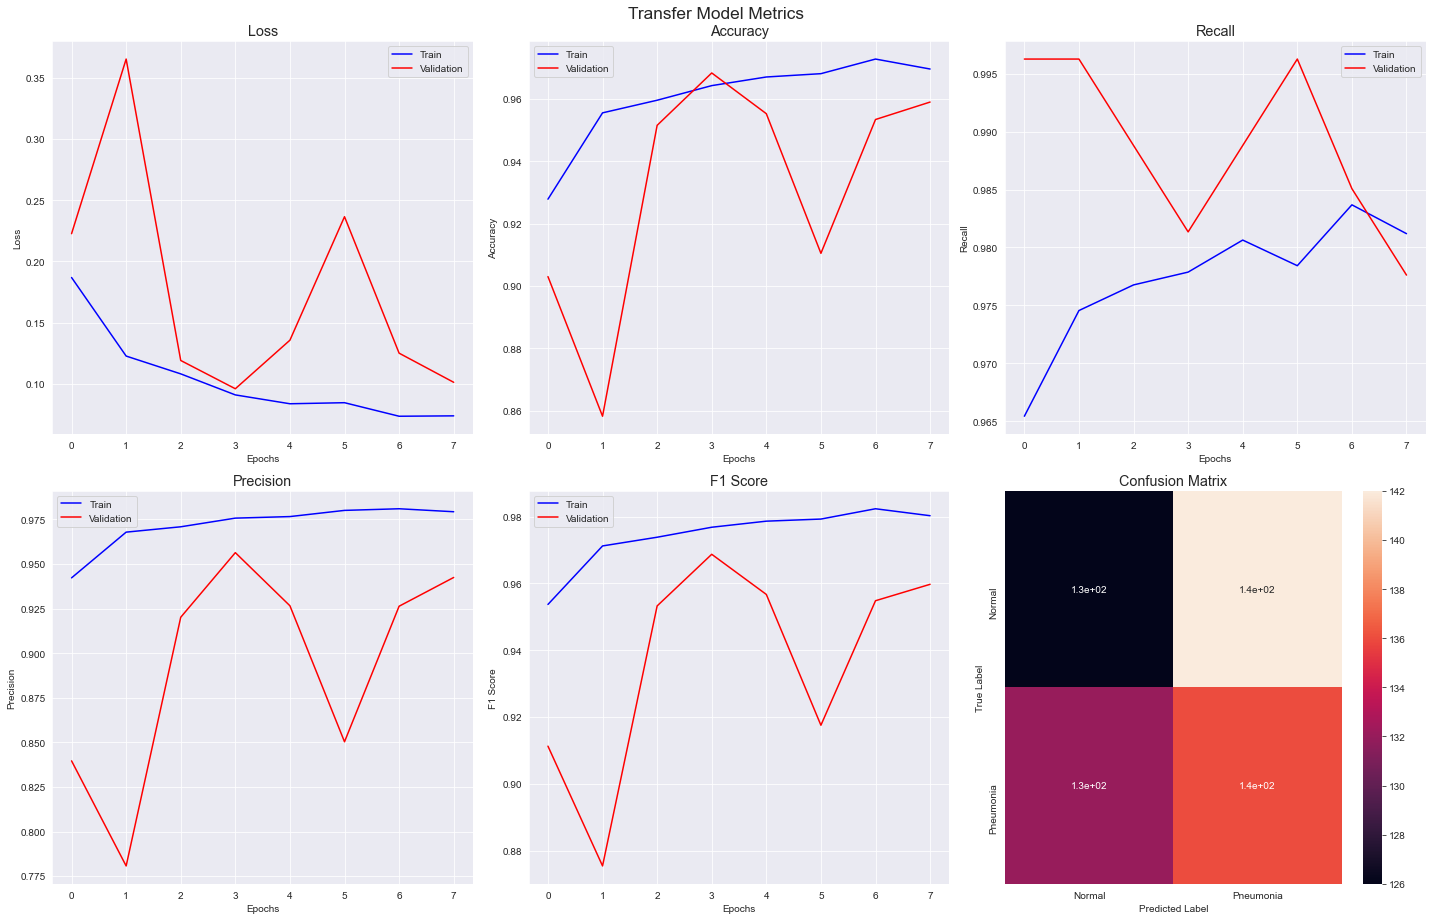

In [59]:
train_metrics, val_metrics, cnfs_mtrx = create_metric_lists(transfer_model_history,
                                                            transfer_model,
                                                            val_generator,
                                                            val_labels_reshaped)
all_model_metrics = record_all(all_model_metrics, 
                               val_metrics, 
                               'Transfer', 
                               execution_time, 
                               cnfs_mtrx,
                               callback.stopped_epoch)

visualize_metrics(range(callback.stopped_epoch+1), train_metrics, val_metrics, 'Transfer Model', cnfs_mtrx)

In [62]:
import pandas as pd
df = pd.DataFrame.from_dict(all_model_metrics, orient='columns')
df.set_index('Model', inplace=True)
df

,Loss,Accuracy,Recall,Precision,F1 Score,Computation Time,Confusion Matrix
Model,,,,,,,
Baseline Model,0.470313,0.889706,1.000000,0.802632,0.890511,17.994010,"[[60, 15], [0, 61]]"
Baseline 75,0.693696,0.495098,1.000000,0.495098,0.662295,16.992717,"[[0, 206], [0, 202]]"
CNN,0.147716,0.953358,0.985075,0.926316,0.954792,1457.614667,"[[132, 136], [119, 149]]"
CNN with Reg,0.267521,0.902985,0.996269,0.839623,0.911263,3172.427675,"[[109, 159], [109, 159]]"
Transfer,0.101348,0.958955,0.977612,0.942446,0.959707,2659.348256,"[[126, 142], [132, 136]]"


In [65]:
df['Confusion Matrix']

Model
Baseline Model         [[60, 15], [0, 61]]
Baseline 75           [[0, 206], [0, 202]]
CNN               [[132, 136], [119, 149]]
CNN with Reg      [[109, 159], [109, 159]]
Transfer          [[126, 142], [132, 136]]
Name: Confusion Matrix, dtype: object

- intro --> distribution of pixel values?
- Choose Final Model (with explanation)
- Evaluate Final Model with Test Group
- Visuals --> tenserboard? 
    - explain model structure
    - What is most important to model -- how is it making its predictions? how can we use that information for a recommendation
    - Activaton layers (LIME library) --> show stakeholders ways to interpret model to gain insight --> which pixels most important --> further research into that area of lungs?
    - Final Recommendation?
    - Research False Negatives --> why? any commonalities between images? where is model weak?
    
- Seperate document for google colab (want to include?)
- clean up markdown sections
- 

# Final Model Evaluation

- choose final model + give reasonings as to why
- evaluate final model with holdout test data

- Visualize model structure!! Connect to Recommendations.

In [ ]:
#final_model_results = final_model.evaluate(test_generator)
#print(results)

In [72]:
# Model's architecture
from tensorflow.keras.utils import plot_model
plot_model(cnn, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
# FROM MORGAN'S

# Extract Layer Names for Labelling
#layer_names = []
#for layer in reg_model.layers[:8]:
#    layer_names.append(layer.name)

#total_features = sum([a.shape[-1] for a in activations])
#total_features

#n_cols = 16
#n_rows = math.ceil(total_features / n_cols)


#iteration = 0
#fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

#for layer_n, layer_activation in enumerate(activations):
#    n_channels = layer_activation.shape[-1]
#    for ch_idx in range(n_channels):
#        row = iteration // n_cols
#        column = iteration % n_cols
    
#        ax = axes[row, column]

#        channel_image = layer_activation[0,
#                                         :, :,
#                                         ch_idx]
        # Post-process the feature to make it visually palatable
#        channel_image -= channel_image.mean()
#        channel_image /= channel_image.std()
#        channel_image *= 64
#        channel_image += 128
#        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
               
#        ax.imshow(channel_image, aspect='auto', cmap='viridis')
#        ax.get_xaxis().set_ticks([])
#        ax.get_yaxis().set_ticks([])
        
#        if ch_idx == 0:
#            ax.set_title(layer_names[layer_n], fontsize=10)
#        iteration += 1

#fig.subplots_adjust(hspace=1.25)
#plt.savefig('Intermediate_Activations_Visualized.pdf')
#plt.show()

## Recommendations